<a href="https://colab.research.google.com/github/AmirHesamKamalpour/Unsupervised_Server_Log_Anomaly_Detection/blob/main/Unsupervised_Server_Log_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**AmirHesam Kamalpour**
## ***Unsupervised Server Log Anomaly Detection***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Importing required libraries***

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
from sklearn.utils import shuffle
from tensorflow import keras
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.models import  Model, Sequential
from keras.layers import Dense, Input, BatchNormalization
from sklearn.ensemble import IsolationForest
from keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/output-rahnema.log',sep='delimiter', header=None)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
df

,0
0,207.213.193.143 [2021-5-12T5:6:0.0+0430] [Get ...
1,207.213.193.143 [2021-5-12T5:6:0.0+0430] [Get ...
2,35.110.222.153 [2021-5-12T5:6:0.0+0430] [Get /...
3,35.108.208.99 [2021-5-12T5:6:0.0+0430] [Get im...
4,35.110.222.153 [2021-5-12T5:6:0.0+0430] [Get i...
...,...
1260030,35.117.86.75 [2021-5-12T15:8:59.0+0430] [Get i...
1260031,35.117.86.75 [2021-5-12T15:8:59.0+0430] [Get f...
1260032,153.126.251.199 [2021-5-12T15:8:59.0+0430] [Ge...
1260033,207.213.207.102 [2021-5-12T15:8:59.0+0430] [Ge...


# **Train_Test split function**
## (Size of the data > 1 million) --> (99 % train , 1 % test)

In [ ]:
def _split_data(x_data, train_ratio=0.99, split_type='uniform'):
  num_train = int(train_ratio * x_data.shape[0])
  x_train = x_data[0:num_train]
  x_test = x_data[num_train:]

  indexes = shuffle(np.arange(x_train.shape[0]))
  x_train = x_train[indexes]

  return x_train,x_test

## Functions using `regex` to turn the dataframe with **`1 column`** into `7 different columns` 

### `First Column`: The users IP address
### `Second Column`: Timestamp when the request is made
### `Third Column`: The request sent from the client
### `4th Column`: Status code sent by the server
### `5th Column`: The size of the object returned to the client
### `6th Column`: Referred site
### `7th Column`: Agent Info


In [ ]:
def Create_ID(row):  
    return re.findall('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', row)
  
def TimeStamp(row):  
    return re.findall('\[\d{4}-\d-\d{2}T\d{1,2}:\d{1,2}:\d{1,2}\.\d{1}\+\d{4}\]', row)

def Client_Request(row):
  return re.findall('\[[^0-9,\[]{3,4}[^\]]*\]', row)

def status_size(row):
  return re.findall('\s\d*\s\d*\s', row)

def find_all(row):
  return re.findall(r'-?\d+\.?\d*', row)

def agent_info(row):
  return re.findall('\s\d*$', row)

In [ ]:
df['Id'] = df[0].apply(Create_ID)
df['Id'] = pd.DataFrame(df['Id'].tolist(), index= df.index)[0]
df['TimeStamp'] = df[0].apply(TimeStamp)
df['Request'] = df[0].apply(Client_Request)
df['Request'] = [','.join(map(str, l)) for l in df['Request']]
df[['Referred_Site','Client_Request']] = df['Request'].str.split(",",1,expand = True)
df = df.drop('Request', axis=1)
df['ss'] = df[0].apply(status_size)
df['ss'] = [' '.join(map(str, l)) for l in df['ss']]
df['ss'] =df['ss'].apply(find_all)
df[['Status','Size']] = pd.DataFrame(df.ss.tolist(), index= df.index)
df = df.drop('ss',axis = 1)
df['Agent_Info'] = df[0].apply(agent_info)
df['Agent_Info'] = [' '.join(map(str, l)) for l in df['Agent_Info']]
df['Agent_Info'] = df['Agent_Info'].apply(find_all)
df['Agent_Info'] = pd.DataFrame(df['Agent_Info'].tolist(), index= df.index)
df = df.drop(0,axis = 1)
df['TimeStamp'] = pd.DataFrame(df['TimeStamp'].tolist(), index= df.index)
df['TimeStamp'] = df['TimeStamp'].str.replace('[' , '')
df['TimeStamp'] = df['TimeStamp'].str.replace(']' , '')
df['Referred_Site'] = df['Referred_Site'].str.replace('[' , '')
df['Referred_Site'] = df['Referred_Site'].str.replace(']' , '')
df['Client_Request'] = df['Client_Request'].str.replace('[' , '')
df['Client_Request'] = df['Client_Request'].str.replace(']' , '')

<ipython-input-17-a7e27fdd7918>:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['TimeStamp'] = df['TimeStamp'].str.replace('[' , '')
<ipython-input-17-a7e27fdd7918>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['TimeStamp'] = df['TimeStamp'].str.replace(']' , '')
<ipython-input-17-a7e27fdd7918>:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Referred_Site'] = df['Referred_Site'].str.replace('[' , '')
<ipython-input-17-a7e27fdd7918>:22: FutureWarning: The default value of regex will change from True to F

In [ ]:
df

,Id,TimeStamp,Referred_Site,Client_Request,Status,Size,Agent_Info
0,207.213.193.143,2021-5-12T5:6:0.0+0430,Get /cdn/profiles/1026106239,Googlebot-Image/1.0,304,0,32
1,207.213.193.143,2021-5-12T5:6:0.0+0430,Get images/badge.png,Googlebot-Image/1.0,304,0,4
2,35.110.222.153,2021-5-12T5:6:0.0+0430,Get /pages/630180847,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,200,52567,32
3,35.108.208.99,2021-5-12T5:6:0.0+0430,Get images/fav_icon2.ico,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,200,23531,20
4,35.110.222.153,2021-5-12T5:6:0.0+0430,Get images/sanjagh_logo_purpule5.png,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,200,4680,8
...,...,...,...,...,...,...,...
1260030,35.117.86.75,2021-5-12T15:8:59.0+0430,Get images/graystar_min.png,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,304,0,4
1260031,35.117.86.75,2021-5-12T15:8:59.0+0430,Get fonts/sanjagh_icon_font_5.woff,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,304,0,4
1260032,153.126.251.199,2021-5-12T15:8:59.0+0430,Get /api/v2/connect/215865643,okhttp/3.12.1,101,0,60003
1260033,207.213.207.102,2021-5-12T15:8:59.0+0430,Get /cdn/profiles/1289255230,Googlebot-Image/1.0,304,0,20


## ***Preprocessing data***:
### `1`: Tokenization
### `2`: Padding sequences
### `3`: Shuffle data
### `4`: Normalization between 0 and 1

In [ ]:
def preprocess_train_test(df):
  max_words = 20000
  samples = []

  df = df.sample(frac = 1)
  df = df.reset_index()
  df = df.drop('index',axis =1)

  for row in df.iterrows():
    index, data = row
    samples.append(data.tolist())

  tokenizer = Tokenizer(num_words=max_words, lower= False)
  tokenizer.fit_on_texts(samples)
  sequences = tokenizer.texts_to_sequences(samples)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  data = pad_sequences(sequences)

  train,test = _split_data(data)

  min_val = np.min(train)
  max_val = np.max(train)

  train = (train - min_val) / (max_val - min_val)
  test = (test - min_val) / (max_val - min_val)

  return train,test

In [ ]:
train,test = preprocess_train_test(df)

Found 317336 unique tokens.


In [ ]:
train.shape , test.shape

((1247434, 7), (12601, 7))

# ***Model***: Two deep ***Autoencoder*** networks and an ***Isolation Forest***
## `Isolation Forest`: Used to find positive logs rather than anomalies

## `First Autoencoder`: Feature extraction from a small amount of data in an unsupervised way. output of the first Autoencoder is fed to the Isolation Forest

## `Second Autoencoder`: Gets the output of the Isolation Forest as input and has same architecture as the first Autoencoder.

## `Optimizer` : ADAM

## `Encoding activation func` : Relu

## `Decoding activation funcs` : Relu , `output layer`: Sigmoid

## `Early stopping` : Used to prevent overfitting

## `Threshold` : Standard deviation above the mean of the feature values of each sample in the output of the first autoencoder.



Epoch 1/10
19492/19492 [==============================] - 114s 6ms/step - loss: 0.0355 - accuracy: 0.4476
Epoch 2/10
38983/38983 [==============================] - 70s 2ms/step
Epoch 1/10
19492/19492 [==============================] - 96s 5ms/step - loss: 0.0032 - accuracy: 0.9767
Epoch 2/10
38983/38983 [==============================] - 62s 2ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.13449355347778327
394/394 [==============================] - 1s 2ms/step


,Loss_mae,Anomaly
0,0.175401,True
1,0.067999,False
2,0.074514,False
3,0.085665,False
4,0.109139,False


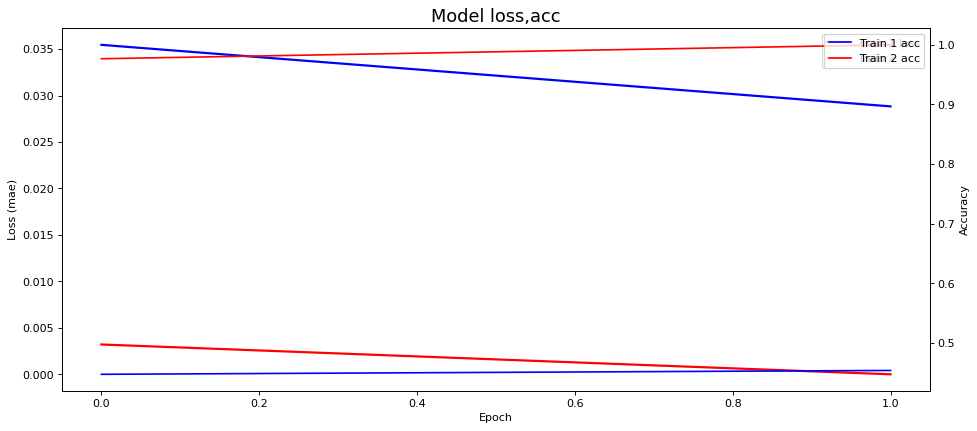

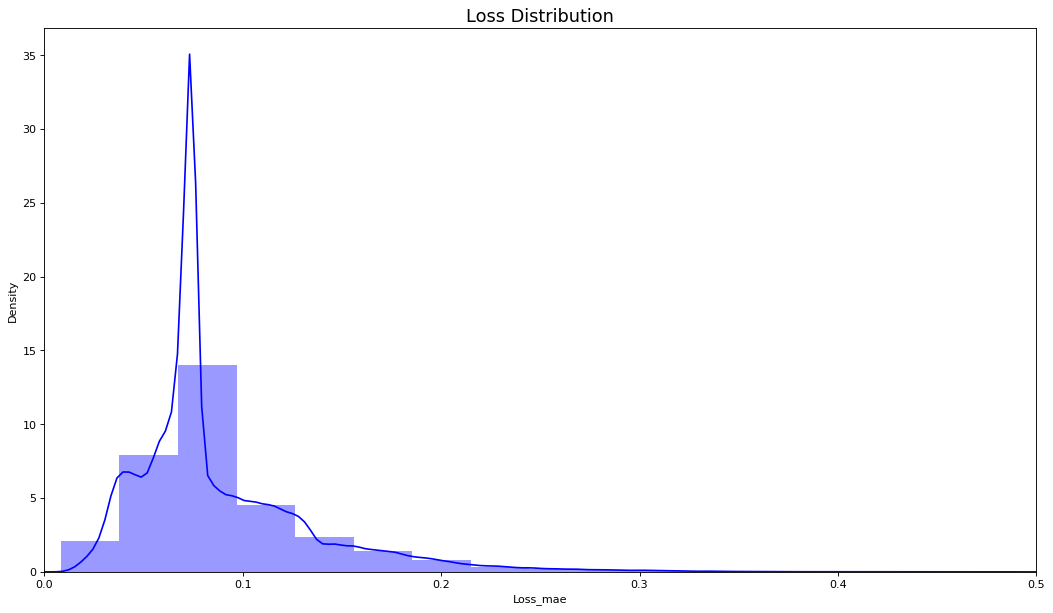

In [ ]:
class AnomalyDetector1(Model):
  def __init__(self,input_dim):
    super(AnomalyDetector1, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(input_dim//3*2,kernel_regularizer=regularizers.l2(0.01),activation="relu"),
      layers.BatchNormalization(),
      layers.Dense(input_dim//3,kernel_regularizer=regularizers.l2(0.01),activation="relu"),
      layers.BatchNormalization(),
      layers.Dense(1,kernel_regularizer=regularizers.l2(0.01),activation="relu"),
      layers.BatchNormalization()]
      )

    self.decoder = tf.keras.Sequential([
      layers.Dense(input_dim//3, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(input_dim//3*2, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(input_dim, activation='sigmoid')]
      )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

class AnomalyDetector2(Model):
  def __init__(self,input_dim):
    super(AnomalyDetector2, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(input_dim//3*2,kernel_regularizer=regularizers.l2(0.01),activation="relu"),
      layers.BatchNormalization(),
      layers.Dense(input_dim//3,kernel_regularizer=regularizers.l2(0.01),activation="relu"),
      layers.BatchNormalization()]
      )

    self.decoder = tf.keras.Sequential([
      layers.Dense(input_dim//3, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(input_dim//3*2, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(input_dim, activation='sigmoid')]
      )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

iso_forest_rate = 0.3

autoencoder1 = AnomalyDetector1(train.shape[1])

early_stopping = EarlyStopping(monitor='loss', mode='min')

autoencoder1.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

history1 = autoencoder1.fit(train,train,
                            epochs=10,
                            batch_size=64,
                            shuffle=True,
                            callbacks = [early_stopping])

f1_pre = autoencoder1.predict(train)

clf = IsolationForest(random_state = 42, contamination = iso_forest_rate)

clf.fit(f1_pre)

pred = clf.predict(f1_pre)

p1 = f1_pre[pred==1]
p2 = f1_pre[pred==-1]

autoencoder2 = AnomalyDetector2(p1.shape[1])

early_stopping = EarlyStopping(monitor='loss', mode='min')

autoencoder2.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

history2 = autoencoder2.fit(p1, p1, 
                            epochs=10,
                            batch_size=64, 
                            shuffle=True, 
                            callbacks = [early_stopping])

fig, loss_ax = plt.subplots(figsize=(14, 6), dpi=80)
acc_ax = loss_ax.twinx()
loss_ax.plot(history1.history['loss'], 'b', label='Train 1 loss', linewidth=2)
loss_ax.plot(history2.history['loss'], 'r', label='Train 2', linewidth=2)
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss (mae)')
loss_ax.legend(loc='upper right')

acc_ax.plot(history1.history['accuracy'], 'b', label='Train 1 acc')
acc_ax.plot(history2.history['accuracy'], 'r', label='Train 2 acc')
acc_ax.set_ylabel('Accuracy')
acc_ax.legend(loc='upper right')

loss_ax.set_title('Model loss,acc', fontsize=16)

  # plot the loss distribution of the training set
X_pred = autoencoder1.predict(train)
X_pred = autoencoder2.predict(X_pred)
X_pred = pd.DataFrame(X_pred)

train_scored = pd.DataFrame()
Xtrain = train
train_scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(train_scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

  # calculate the same metrics for the training set 
  # and merge all data in a single dataframe for plotting
threshold = np.mean(train_scored['Loss_mae']) + np.std(train_scored['Loss_mae'])
print(threshold)

X_pred_train = autoencoder2.predict(autoencoder1.predict(train))
X_pred_train = pd.DataFrame(X_pred_train)

scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = scored_train.quantile(threshold)[0]
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

  
  # calculate the loss on the test set
X_pred = autoencoder2.predict(autoencoder1.predict(test))
X_pred = pd.DataFrame(X_pred)

scored = pd.DataFrame()
Xtest = test
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Anomaly'] = scored['Loss_mae'] > threshold
scored.head() 

In [ ]:
scored['Anomaly'].value_counts()

False    10962
True      1639
Name: Anomaly, dtype: int64